#### 1. Loading dataset

In [1]:
## https://keras.io/examples/vision/siamese_contrastive/

In [2]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

2023-07-28 04:50:05.086545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 04:50:06.070609: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-07-28 04:50:06.070710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [3]:
from sklearn.datasets import fetch_lfw_pairs

lfw_dataset_train = fetch_lfw_pairs(subset='train',color=True)
lfw_dataset_test = fetch_lfw_pairs(subset='test',color=True)

In [4]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):

    num_row = to_show // num_col if to_show // num_col != 0 else 1
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):

        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(tf.concat([pairs[i][0], pairs[i][1]], axis=1), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

In [5]:
X_train = lfw_dataset_train.pairs
y_train = lfw_dataset_train['target']

X_test = lfw_dataset_test.pairs
y_test = lfw_dataset_test['target']

In [6]:
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

2023-07-28 04:50:10.132814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 04:50:10.144976: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 04:50:10.146698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-28 04:50:10.148826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

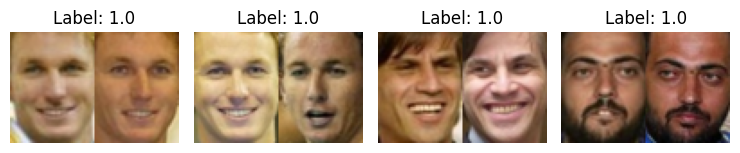

In [7]:
visualize(X_train[:-1], y_train[:-1], to_show=4, num_col=4)

In [8]:
X_train.shape

(2200, 2, 62, 47, 3)

In [56]:
# base_cnn = tf.keras.applications.ResNet50(
#     weights="imagenet", input_shape=(62, 47) + (3,), include_top=False
# )

# flatten = layers.Flatten()(base_cnn.output)
# dense1 = layers.Dense(512, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(256, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)
# output = layers.Dense(256)(dense2)

# embedding = keras.Model(base_cnn.input, output, name="Embedding")

# trainable = False
# for layer in base_cnn.layers:
#     if layer.name == "conv5_block1_out":
#         trainable = True
#     layer.trainable = trainable


# input_1 = layers.Input((62, 47, 3))
# input_2 = layers.Input((62, 47, 3))

# tower_1 = embedding(input_1)
# tower_2 = embedding(input_2)


# merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
# normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
# output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
# siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)


In [57]:
siamese.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 62, 47, 3)]  0           []                               
                                                                                                  
 input_27 (InputLayer)          [(None, 62, 47, 3)]  0           []                               
                                                                                                  
 Embedding (Functional)         (None, 256)          27982720    ['input_26[0][0]',               
                                                                  'input_27[0][0]']               
                                                                                                  
 lambda_3 (Lambda)              (None, 1)            0           ['Embedding[0][0]',        

In [73]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((62, 47, 1))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((62, 47, 1))
input_2 = layers.Input((62, 47, 1))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

In [74]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [85]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
siamese.compile(loss=loss(margin=margin), optimizer=opt, metrics=["accuracy"])
siamese.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 62, 47, 1)]  0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 62, 47, 1)]  0           []                               
                                                                                                  
 model_5 (Functional)           (None, 10)           23238       ['input_29[0][0]',               
                                                                  'input_30[0][0]']               
                                                                                                  
 lambda_4 (Lambda)              (None, 1)            0           ['model_5[0][0]',          

In [105]:
# Convert RGB to grayscale
X_train_gray = np.dot(X_train[..., :3], [0.2989, 0.5870, 0.1140])

# Expand the dimensions to have the shape (2200, 62, 47, 1)
X_train_gray = np.expand_dims(X_train_gray, axis=-1)

X_train_gray = np.squeeze(X_train_gray, axis=-1)

X_train_gray.shape

(2200, 2, 62, 47)

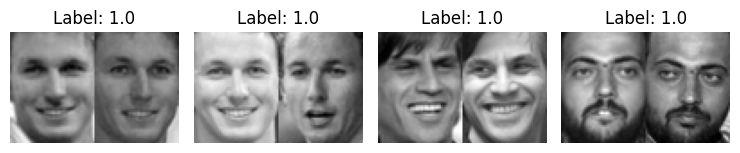

In [106]:
visualize(X_train_gray[:-1], y_train[:-1], to_show=4, num_col=4)

In [107]:
# Convert RGB to grayscale
X_test_gray = np.dot(X_test[..., :3], [0.2989, 0.5870, 0.1140])

# Expand the dimensions to have the shape (2200, 62, 47, 1)
X_test_gray = np.expand_dims(X_test_gray, axis=-1)

X_test_gray = np.squeeze(X_test_gray, axis=-1)

X_test_gray.shape

(1000, 2, 62, 47)

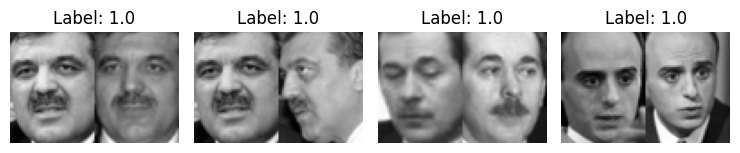

In [108]:
visualize(X_test_gray[:-1], y_test[:-1], to_show=4, num_col=4)

In [114]:
x_train_1 = X_train_gray[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = X_train_gray[:, 1]

x_test_1 = X_test_gray[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_test_2 = X_test_gray[:, 1]

In [115]:
x_train_1.shape, x_test_1.shape, x_train_2.shape, x_test_2.shape

((2200, 62, 47), (1000, 62, 47), (2200, 62, 47), (1000, 62, 47))

In [116]:
y_train

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [117]:
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)

from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, LambdaCallback

model_path = os.path.join("weights", "siamese_image_similarity.hd5")
checkPoint = ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10)

In [118]:
epochs = 50
batch_size = 16
margin = 1  # Margin for contrastive loss.

In [ ]:
with tf.device('/GPU:0'):
    history = siamese.fit(
        [x_train_1, x_train_2],
        y_train,
        validation_data=([x_test_1, x_test_2], y_test),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[reduceLROnPlato, checkPoint]
    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


138/138 [==============================] - ETA: 0s - loss: 0.2472 - accuracy: 0.5614
Epoch 1: val_loss improved from inf to 0.23795, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


138/138 [==============================] - 14s 99ms/step - loss: 0.2472 - accuracy: 0.5614 - val_loss: 0.2379 - val_accuracy: 0.6100 - lr: 0.0100
Epoch 2/50
138/138 [==============================] - ETA: 0s - loss: 0.2452 - accuracy: 0.5618
Epoch 2: val_loss did not improve from 0.23795
138/138 [==============================] - 11s 82ms/step - loss: 0.2452 - accuracy: 0.5618 - val_loss: 0.2398 - val_accuracy: 0.5850 - lr: 0.0100
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.2431 - accuracy: 0.5727
Epoch 3: val_loss did not improve from 0.23795
138/138 [==============================] - 11s 81ms/step - loss: 0.2431 - accuracy: 0.5727 - val_loss: 0.2408 - val_accuracy: 0.5850 - lr: 0.0100
Epoch 4/50
138/138 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.5705
Epoch 4: val_loss did not improve from 0.23795
138/138 [==============================] - 11s 83ms/step - loss: 0.2445 - accuracy: 0.5705 - val_loss: 0.2401 - val_accuracy: 0.5880 

INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


138/138 [==============================] - 14s 104ms/step - loss: 0.2428 - accuracy: 0.5773 - val_loss: 0.2376 - val_accuracy: 0.5990 - lr: 0.0100
Epoch 6/50
138/138 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.5809
Epoch 6: val_loss improved from 0.23764 to 0.23754, saving model to weights/siamese_image_similarity.hd5


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


INFO:tensorflow:Assets written to: weights/siamese_image_similarity.hd5/assets


138/138 [==============================] - 14s 99ms/step - loss: 0.2409 - accuracy: 0.5809 - val_loss: 0.2375 - val_accuracy: 0.6250 - lr: 0.0100
Epoch 7/50
138/138 [==============================] - ETA: 0s - loss: 0.2399 - accuracy: 0.5873
Epoch 7: val_loss did not improve from 0.23754
138/138 [==============================] - 11s 82ms/step - loss: 0.2399 - accuracy: 0.5873 - val_loss: 0.2383 - val_accuracy: 0.5870 - lr: 0.0100
Epoch 8/50
138/138 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.5732
Epoch 8: val_loss did not improve from 0.23754
138/138 [==============================] - 11s 80ms/step - loss: 0.2409 - accuracy: 0.5732 - val_loss: 0.2430 - val_accuracy: 0.5560 - lr: 0.0100
Epoch 9/50
138/138 [==============================] - ETA: 0s - loss: 0.2451 - accuracy: 0.5636
Epoch 9: val_loss did not improve from 0.23754
138/138 [==============================] - 11s 83ms/step - loss: 0.2451 - accuracy: 0.5636 - val_loss: 0.2453 - val_accuracy: 0.5580 

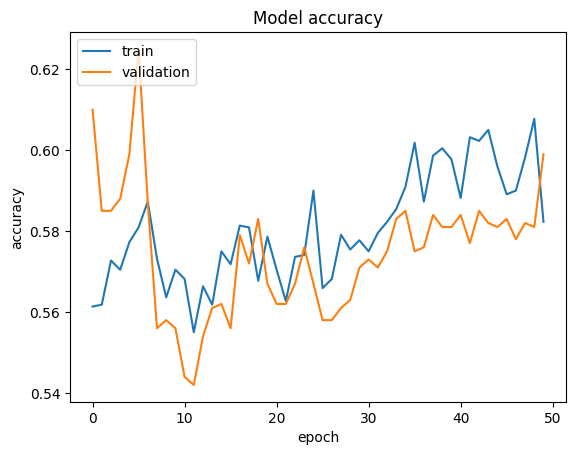

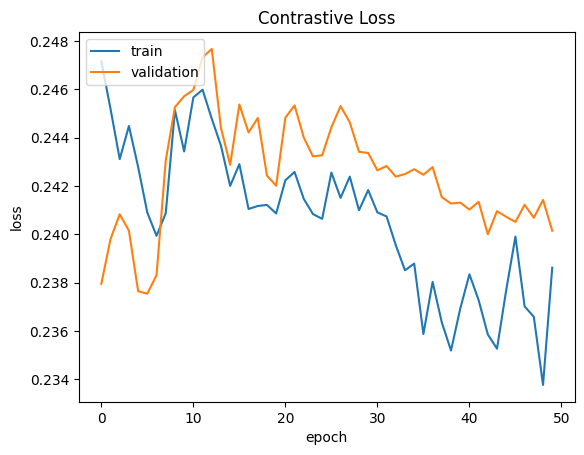

In [123]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")


In [124]:
results = siamese.evaluate([x_test_1, x_test_2], y_test)
print("test loss, test acc:", results)

32/32 [==============================] - 1s 19ms/step - loss: 0.2401 - accuracy: 0.5990
test loss, test acc: [0.2401454597711563, 0.5989999771118164]


32/32 [==============================] - 0s 12ms/step


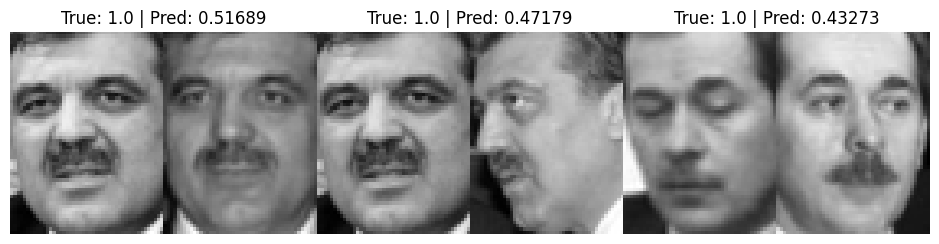

In [125]:
predictions = siamese.predict([x_test_1, x_test_2])
visualize(X_test_gray, y_test, to_show=5, predictions=predictions, test=True)

In [128]:
y_test

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [130]:
a = []
for i in predictions:
    if i[0] >= 0.5:
        a.append(float(1))
    else:
        a.append(float(0))

In [131]:
pred = np.array(a)

In [133]:
from sklearn.metrics import confusion_matrix, classification_report

target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.66      0.59      0.62       557
      Same person       0.54      0.61      0.57       443

         accuracy                           0.60      1000
        macro avg       0.60      0.60      0.60      1000
     weighted avg       0.61      0.60      0.60      1000

